<a href="https://colab.research.google.com/github/vekoada/tensorflow-course/blob/main/06_transfer_learning_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This section will use all 101 classes from the Food Vision 101 dataset.
Up till now, we've only worked with subsets.

The new goal is to outperform the original Food 101 paper with 10% of the training data. The original paper leveraged random forest to get 50.76% accuracy.

Our model uses deep learning. Though it's not a fair comparison, it shows the power of transfer learning and the advances in recent years.



In [ ]:
!nvidia-smi

Wed Sep 20 15:14:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!wget https://raw.githubusercontent.com/vekoada/tensorflow-course/main/helper_functions.py

--2023-09-21 15:34:17--  https://raw.githubusercontent.com/vekoada/tensorflow-course/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6734 (6.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-09-21 15:34:17 (74.8 MB/s) - ‘helper_functions.py’ saved [6734/6734]



In [2]:
#Importing helper functions w
from helper_functions import tensorboard, plot_loss, unzip, compare_histories, dirwalk

In [3]:
#Getting the preprocessed data
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip'
filename = '101_food_classes_10_percent.zip'
unzip(url=url, filename=filename)

Successfully unzipped 101_food_classes_10_percent.zip


In [4]:
#Set up directories
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [ ]:
dirwalk('101_food_classes_10_percent')

2 directories and 0 images in 101_food_classes_10_percent
101 directories and 0 images in 101_food_classes_10_percent/test
0 directories and 250 images in 101_food_classes_10_percent/test/donuts
0 directories and 250 images in 101_food_classes_10_percent/test/falafel
0 directories and 250 images in 101_food_classes_10_percent/test/edamame
0 directories and 250 images in 101_food_classes_10_percent/test/hamburger
0 directories and 250 images in 101_food_classes_10_percent/test/mussels
0 directories and 250 images in 101_food_classes_10_percent/test/macarons
0 directories and 250 images in 101_food_classes_10_percent/test/spring_rolls
0 directories and 250 images in 101_food_classes_10_percent/test/macaroni_and_cheese
0 directories and 250 images in 101_food_classes_10_percent/test/spaghetti_bolognese
0 directories and 250 images in 101_food_classes_10_percent/test/ramen
0 directories and 250 images in 101_food_classes_10_percent/test/red_velvet_cake
0 directories and 250 images in 101_f

In [5]:
#Set up inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #Setting to False so we can analyze later

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
#Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                monitor='val_accuracy',
                                                save_best_only=True)

In [ ]:
#Data augmentation layer
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2) #tack on rescaling layer if model doesn't have built-in scaling
], name='data_aug')

In [ ]:
# Freeze layers of headless (no top) base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False

#Model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_aug(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool_2D_layer')(x)
outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug (Sequential)       (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_2D_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (50

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.F1Score()])

In [ ]:
history = model.fit(train_data_all_10_percent,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.1*len(test_data)),
                    callbacks=[checkpoint])

Epoch 1/5
237/237 [==============================] - 127s 471ms/step - loss: 3.3847 - accuracy: 0.2665 - precision: 0.9679 - recall: 0.0239 - f1_score: 0.2568 - val_loss: 2.4669 - val_accuracy: 0.4755 - val_precision: 1.0000 - val_recall: 0.0570 - val_f1_score: 0.0610
Epoch 2/5
237/237 [==============================] - 81s 334ms/step - loss: 2.1978 - accuracy: 0.4999 - precision: 0.9405 - recall: 0.1481 - f1_score: 0.4873 - val_loss: 2.0347 - val_accuracy: 0.5241 - val_precision: 0.9389 - val_recall: 0.1764 - val_f1_score: 0.0662
Epoch 3/5
237/237 [==============================] - 72s 301ms/step - loss: 1.8248 - accuracy: 0.5677 - precision: 0.9172 - recall: 0.2471 - f1_score: 0.5599 - val_loss: 1.8406 - val_accuracy: 0.5491 - val_precision: 0.9181 - val_recall: 0.2615 - val_f1_score: 0.0689
Epoch 4/5
237/237 [==============================] - 63s 262ms/step - loss: 1.6062 - accuracy: 0.6082 - precision: 0.9293 - recall: 0.3246 - f1_score: 0.6019 - val_loss: 1.7388 - val_accuracy: 0.

In [ ]:
results = model.evaluate(test_data)

790/790 [==============================] - 61s 77ms/step - loss: 1.5725 - accuracy: 0.5879 - precision: 0.8553 - recall: 0.3785 - f1_score: 0.5827


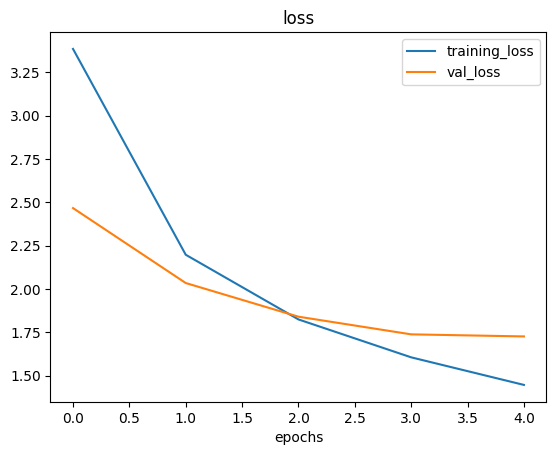

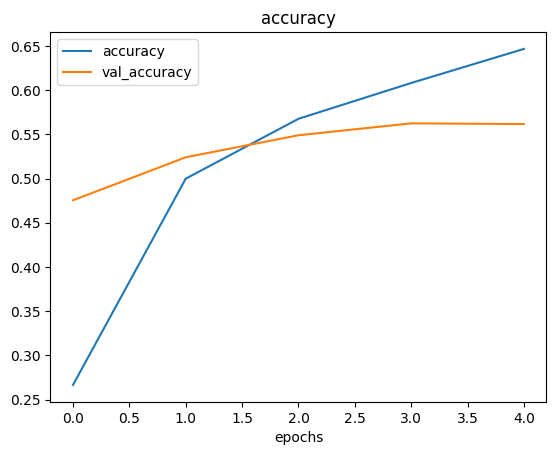

In [ ]:
plot_loss(history)

Already beating the paper, but notice how the validation accuracy plateaus.

### Fine-tuning the model


In [ ]:
#Start by unfreezing all of the layers of the base model
base_model.trainable = True

#Now refreeze all but last 15
for layer in base_model.layers[:-15]:
  layer.trainable=False

In [ ]:
#Recompile with lower learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.F1Score()])

In [ ]:
for layer_n, layer in enumerate(base_model.layers):
  if layer.trainable:
    print(layer_n, layer.name, layer.trainable)

223 block7a_expand_bn True
224 block7a_expand_activation True
225 block7a_dwconv True
226 block7a_bn True
227 block7a_activation True
228 block7a_se_squeeze True
229 block7a_se_reshape True
230 block7a_se_reduce True
231 block7a_se_expand True
232 block7a_se_excite True
233 block7a_project_conv True
234 block7a_project_bn True
235 top_conv True
236 top_bn True
237 top_activation True


In [ ]:
history_fine = model.fit(train_data_all_10_percent,
                         epochs=10,
                         validation_data=test_data,
                         validation_steps=int(0.05*len(test_data)),
                         initial_epoch=history.epoch[-1]) #start where it left off

Epoch 5/10
237/237 [==============================] - 73s 232ms/step - loss: 1.1797 - accuracy: 0.6836 - precision_1: 0.8690 - recall_1: 0.5307 - f1_score: 0.6814 - val_loss: 1.8938 - val_accuracy: 0.5024 - val_precision_1: 0.7056 - val_recall_1: 0.3822 - val_f1_score: 0.0313
Epoch 6/10
237/237 [==============================] - 49s 206ms/step - loss: 1.0411 - accuracy: 0.7180 - precision_1: 0.8853 - recall_1: 0.5789 - f1_score: 0.7157 - val_loss: 1.8903 - val_accuracy: 0.5040 - val_precision_1: 0.7047 - val_recall_1: 0.4054 - val_f1_score: 0.0314
Epoch 7/10
237/237 [==============================] - 45s 190ms/step - loss: 0.9426 - accuracy: 0.7447 - precision_1: 0.8948 - recall_1: 0.6186 - f1_score: 0.7426 - val_loss: 1.9109 - val_accuracy: 0.5040 - val_precision_1: 0.6976 - val_recall_1: 0.4215 - val_f1_score: 0.0311
Epoch 8/10
237/237 [==============================] - 45s 187ms/step - loss: 0.8582 - accuracy: 0.7673 - precision_1: 0.8989 - recall_1: 0.6434 - f1_score: 0.7654 - val_

In [ ]:
results_fine = model.evaluate(test_data)

790/790 [==============================] - 66s 84ms/step - loss: 1.5280 - accuracy: 0.6037 - precision_1: 0.7473 - recall_1: 0.5205 - f1_score: 0.6029


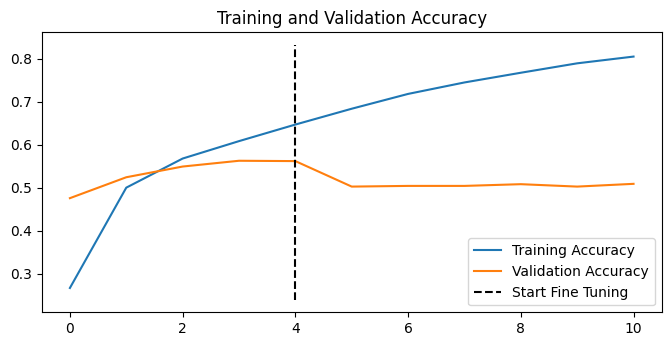

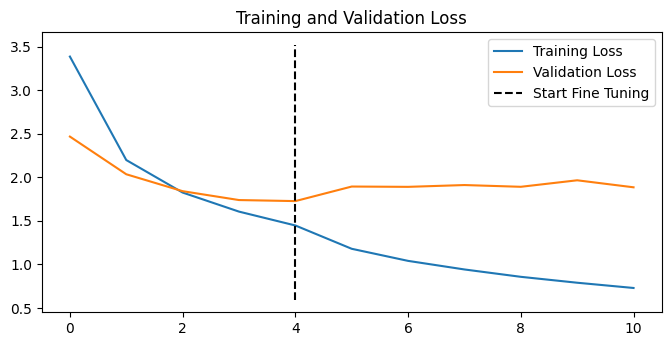

In [ ]:
compare_histories(history, history_fine)

The model is overfitting. Fine-tuning doesn't always work. We'll still save the model.

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_model')

In [6]:
import tensorflow as tf

In [6]:
#Loading back in
loaded_model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_model')
#results_loaded = loaded_model.evaluate(test_data)

In [7]:
#Make predictions with the model
prediction_probs = loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 97s 103ms/step


In [ ]:
len(prediction_probs)

In [ ]:
prediction_probs.shape

In [ ]:
#Look at first one
prediction_probs[0], len(prediction_probs[0])

For every input, the prediction is an array with n elements where n is number of classes. These contain the probabilities assigned to each class.

In [9]:
max = tf.argmax(prediction_probs[0])
test_data.class_names[52] #this is why we didn't shuffle earlier

'gyoza'

In [8]:
#Get predicted class for each prediction
pred_classes = prediction_probs.argmax(axis=1)

In [9]:
#Our current test_data is in a batched format. We need to undo that to compare
y_labels = []
for img, label in test_data.unbatch():
  y_labels.append(label.numpy().argmax())

#Observe first 10
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
#Double check that y_labels and pred_classes are in the same order
#by comparing accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_labels, pred_classes)
acc

0.6036831683168317

That's correct

In [10]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def create_confusion(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=True, vertical_x_labels=False):
  cm = confusion_matrix(y_true, tf.round(y_pred))
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalizing
  n_classes = cm.shape[0]

  #visuals
  fig, ax = plt.subplots(figsize=figsize)

  #plot
  cax=ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  #Classes
  if classes!=None:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  #Label axes
  ax.set(title='CM',
        xlabel='Pred Label',
        ylabel='True Label',
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  #Set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  ##Changed: plot x-labels vertically
  if vertical_x_labels:
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

  #Adjust label size
  ax.xaxis.label.set_size(text_size)
  ax.yaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  #Threshold for colors
  threshold = (cm.max() + cm.min()) / 2.

  #Plot text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
      horizontalalignment='center',
      color='white' if cm[i, j] > threshold else 'black',
      size=text_size)
    else: #Also added this to not print percentages
      plt.text(j, i, f'{cm[i, j]}',
               horizontalalignment='center',
               color='white' if cm[i, j] > threshold else 'black',
               size=text_size)

In [11]:
class_names = test_data.class_names
create_confusion(y_labels,
                 pred_classes,
                 class_names,
                 figsize=(125, 125),
                 text_size=15,
                 norm=False,
                 vertical_x_labels=True)

The matrix is very large and difficult to read. However, when you do figure it out, it is useful to see what classes are confused for other classes. For example, it makes sense that fillet mignon is often predicted for an image of steak given their similarity

In [12]:
#Sklearn's classification report will give precision, recall, and F1 scores for each class
from sklearn.metrics import classification_report
report = classification_report(y_labels, pred_classes, output_dict=True)
print(report)

{'0': {'precision': 0.30434782608695654, 'recall': 0.224, 'f1-score': 0.25806451612903225, 'support': 250}, '1': {'precision': 0.4986376021798365, 'recall': 0.732, 'f1-score': 0.5931928687196111, 'support': 250}, '2': {'precision': 0.5992647058823529, 'recall': 0.652, 'f1-score': 0.6245210727969348, 'support': 250}, '3': {'precision': 0.8181818181818182, 'recall': 0.504, 'f1-score': 0.6237623762376237, 'support': 250}, '4': {'precision': 0.4863636363636364, 'recall': 0.428, 'f1-score': 0.4553191489361702, 'support': 250}, '5': {'precision': 0.4588744588744589, 'recall': 0.424, 'f1-score': 0.4407484407484408, 'support': 250}, '6': {'precision': 0.7481481481481481, 'recall': 0.808, 'f1-score': 0.7769230769230769, 'support': 250}, '7': {'precision': 0.7799227799227799, 'recall': 0.808, 'f1-score': 0.793713163064833, 'support': 250}, '8': {'precision': 0.26256983240223464, 'recall': 0.564, 'f1-score': 0.35832274459974583, 'support': 250}, '9': {'precision': 0.4396551724137931, 'recall': 0.

In [13]:
#Visualize it
class_f1_scores = {}
for k, v in report.items():
  if k == 'accuracy':#Accuracy is last so stop
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.25806451612903225,
 'baby_back_ribs': 0.5931928687196111,
 'baklava': 0.6245210727969348,
 'beef_carpaccio': 0.6237623762376237,
 'beef_tartare': 0.4553191489361702,
 'beet_salad': 0.4407484407484408,
 'beignets': 0.7769230769230769,
 'bibimbap': 0.793713163064833,
 'bread_pudding': 0.35832274459974583,
 'breakfast_burrito': 0.5117056856187291,
 'bruschetta': 0.4942084942084942,
 'caesar_salad': 0.6387665198237885,
 'cannoli': 0.659919028340081,
 'caprese_salad': 0.5513078470824949,
 'carrot_cake': 0.5788336933045356,
 'ceviche': 0.36818181818181817,
 'cheese_plate': 0.610878661087866,
 'cheesecake': 0.40514469453376206,
 'chicken_curry': 0.49446494464944646,
 'chicken_quesadilla': 0.6498951781970651,
 'chicken_wings': 0.7237354085603113,
 'chocolate_cake': 0.5433962264150942,
 'chocolate_mousse': 0.36904761904761907,
 'churros': 0.7584745762711865,
 'clam_chowder': 0.7029126213592233,
 'club_sandwich': 0.6706586826347306,
 'crab_cakes': 0.3705583756345177,
 'creme_brul

In [14]:
#convert to dataframe for viz
import pandas as pd
#Sort
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)


In [15]:
f1_scores.head()

class_names  f1-score
33     edamame  0.962672
63    macarons  0.895397
69     oysters  0.866667
32   dumplings  0.843813
75         pho  0.841121

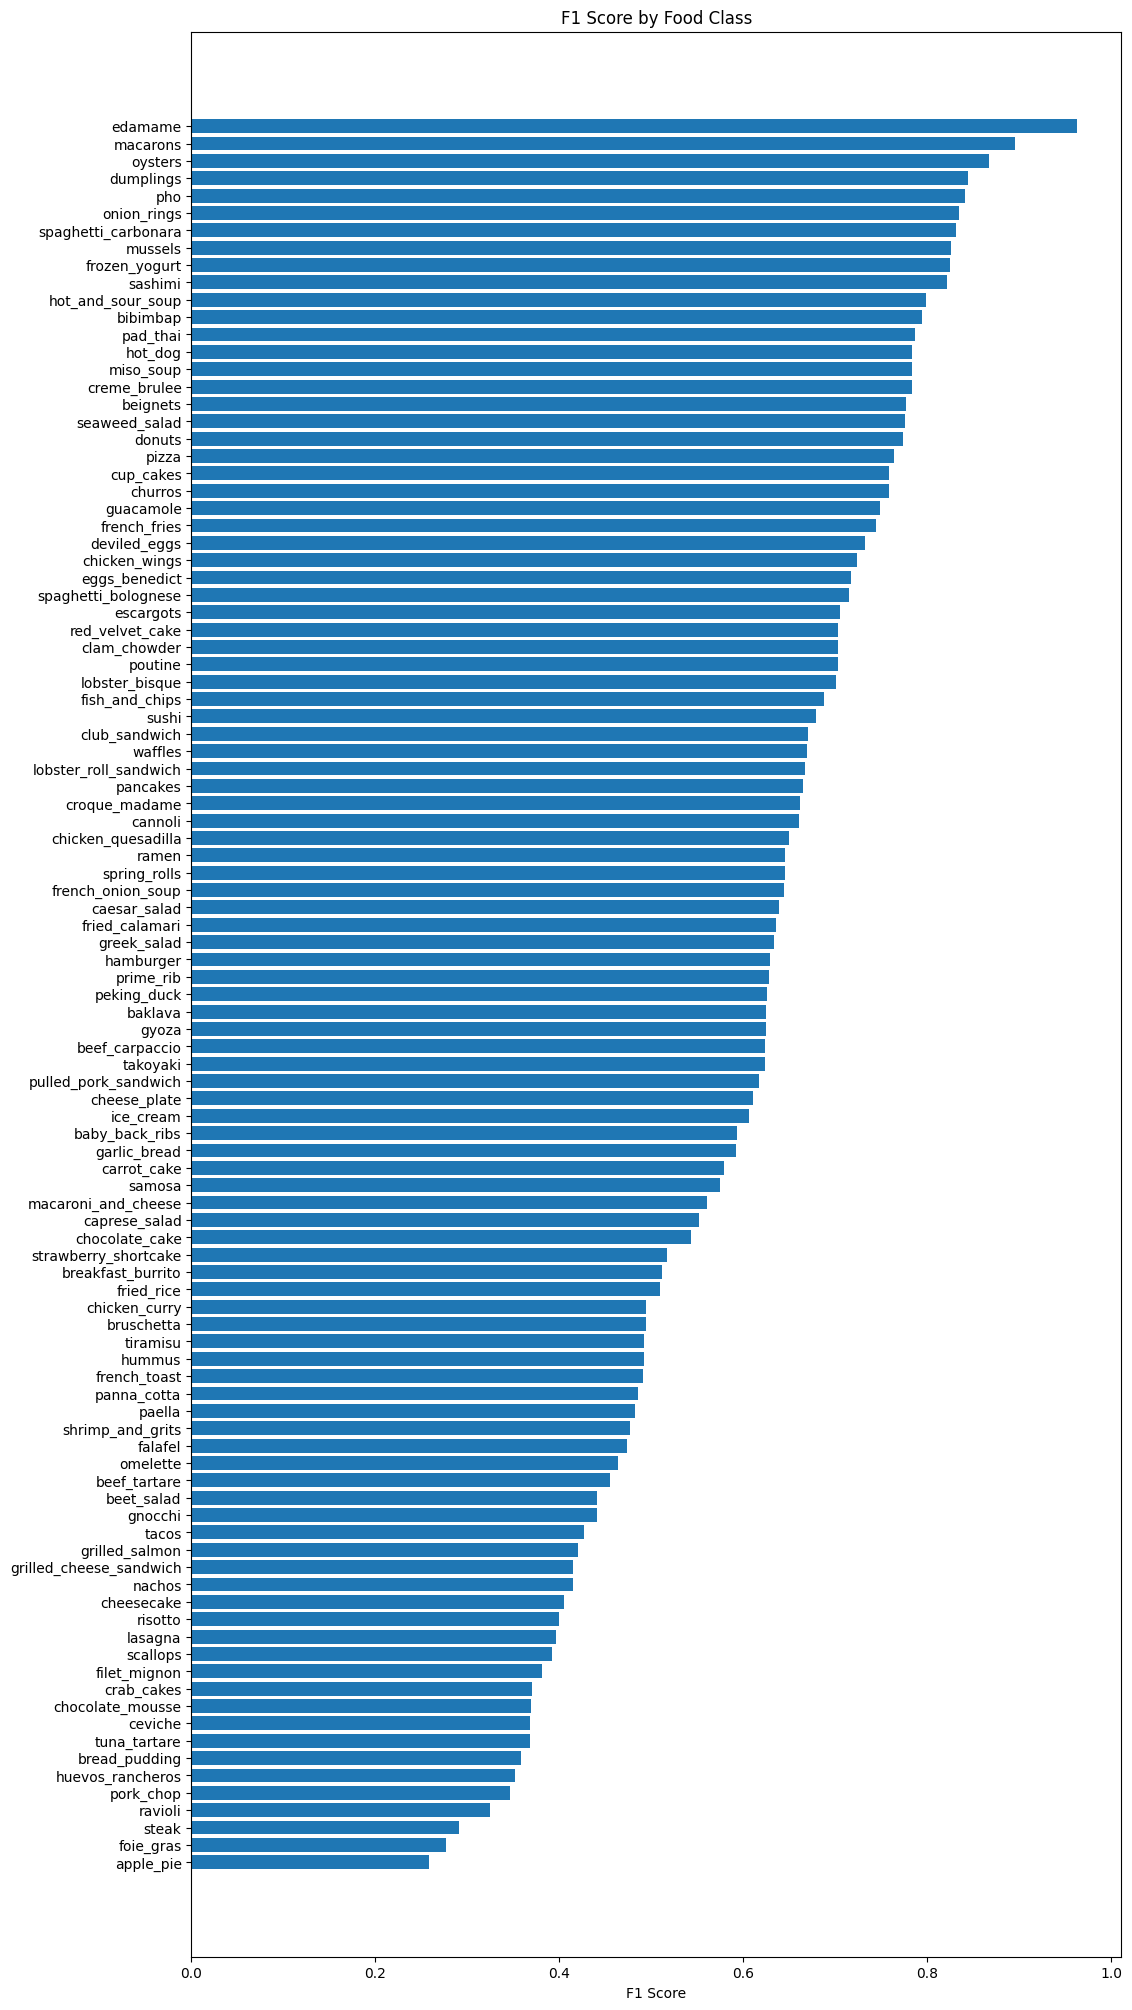

In [36]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1 Score')
ax.set_title('F1 Score by Food Class')
ax.invert_yaxis()

[Text(0, 0, 'edamame'),
 Text(1, 0, 'macarons'),
 Text(2, 0, 'oysters'),
 Text(3, 0, 'dumplings'),
 Text(4, 0, 'pho'),
 Text(5, 0, 'onion_rings'),
 Text(6, 0, 'spaghetti_carbonara'),
 Text(7, 0, 'mussels'),
 Text(8, 0, 'frozen_yogurt'),
 Text(9, 0, 'sashimi'),
 Text(10, 0, 'hot_and_sour_soup'),
 Text(11, 0, 'bibimbap'),
 Text(12, 0, 'pad_thai'),
 Text(13, 0, 'hot_dog'),
 Text(14, 0, 'miso_soup'),
 Text(15, 0, 'creme_brulee'),
 Text(16, 0, 'beignets'),
 Text(17, 0, 'seaweed_salad'),
 Text(18, 0, 'donuts'),
 Text(19, 0, 'pizza'),
 Text(20, 0, 'cup_cakes'),
 Text(21, 0, 'churros'),
 Text(22, 0, 'guacamole'),
 Text(23, 0, 'french_fries'),
 Text(24, 0, 'deviled_eggs'),
 Text(25, 0, 'chicken_wings'),
 Text(26, 0, 'eggs_benedict'),
 Text(27, 0, 'spaghetti_bolognese'),
 Text(28, 0, 'escargots'),
 Text(29, 0, 'red_velvet_cake'),
 Text(30, 0, 'clam_chowder'),
 Text(31, 0, 'poutine'),
 Text(32, 0, 'lobster_bisque'),
 Text(33, 0, 'fish_and_chips'),
 Text(34, 0, 'sushi'),
 Text(35, 0, 'club_sandwic

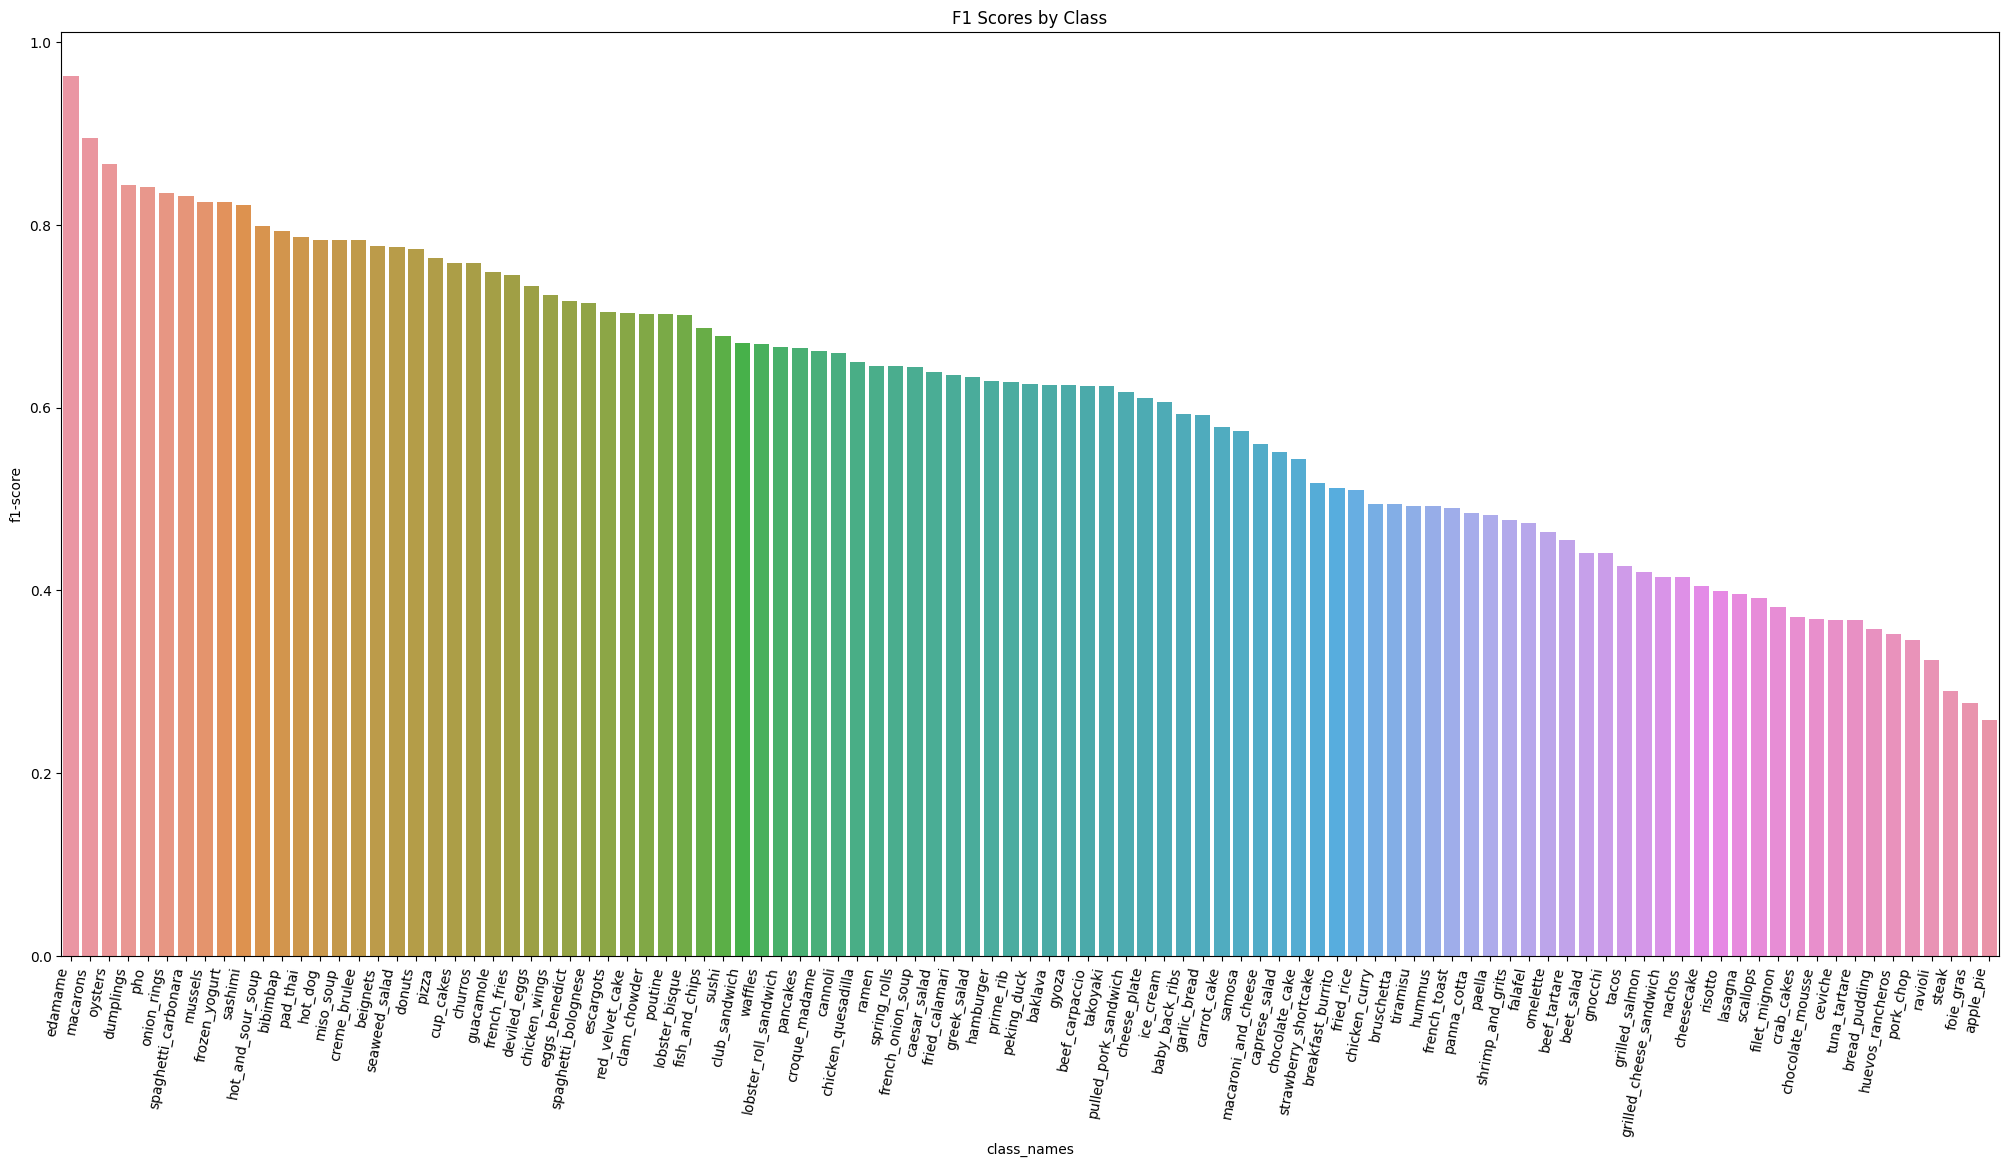

In [41]:
import seaborn as sns
fig, ax_2 = plt.subplots(figsize=(25, 12))
bar = sns.barplot(data = f1_scores, x = f1_scores['class_names'], y= f1_scores['f1-score'], ax=ax_2)
bar.set_title("F1 Scores by Class")
bar.set_xticklabels(bar.get_xticklabels(),
                          rotation=80,
                          horizontalalignment='right')

Visualize test images

In [44]:
#Write function to load and prepare image for prediction
def load_image(path: str, image_shape: int = 224, scale: bool = True) -> tf.Tensor:
    """
    Converts image into tensor and reshapes it into (image_shape, image_shape, color_channels=3).

    Args:
        path (str): Path to the image file.
        image_shape (int): Side dimension of the target size (default is 224).
        scale (bool): Whether to scale pixel values to be between 0 and 1 (default is True).

    Returns:
        img (tf.Tensor): Image tensor of the specified shape.
    """
    # Read in the file
    img = tf.io.read_file(path)

    # Create tensor from image
    img = tf.io.decode_image(img, channels=3)  # Hardcode the channels for consistency (PNG has 4 channels)

    # Resize tensor into model input shape
    img = tf.image.resize(img, size=[image_shape, image_shape])

    # Rescale if not built into model
    if scale:
        return img / 255.
    else:
        return img

1/1 [==============================] - 0s 31ms/step


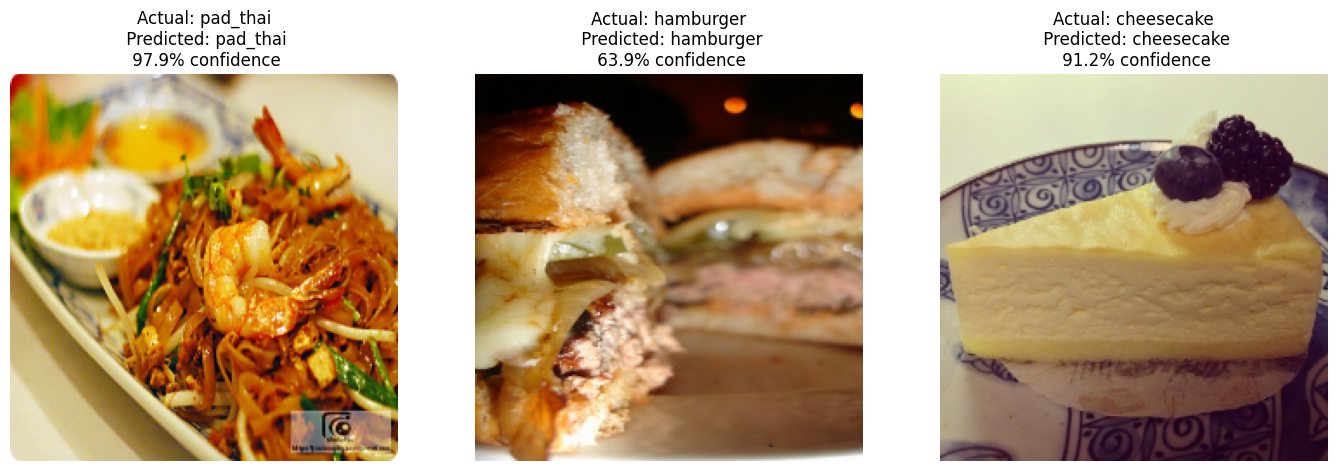

In [61]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  #Choose random image from random class
  actual = random.choice(class_names)
  fname = random.choice(os.listdir(test_dir + '/' + actual))
  path = test_dir + '/' + actual + '/' + fname

  #Load image and predict
  img = load_image(path=path, scale=False)
  probs = loaded_model.predict(tf.expand_dims(img, axis=0)) # add extra dimension since predict expects it
  predicted = class_names[probs.argmax()]

  #Plot the images
  plt.subplot( 1, 3, i+1)
  plt.imshow(img/255.) #Matplotlib needs normalized data to plot correctly
  if actual == predicted:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f'Actual: {actual}\n Predicted: {predicted}\n {probs.max()*100:.1f}% confidence')
  plt.axis(False)

In [68]:
#Identify the 'most wrong' predictions (incorrect class but high probability)

#Get all file paths from test dataset
paths = []
for path in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  paths.append(path.numpy())

25250


In [73]:
#Create dataframe for ease of manipulation + plotting
pred_df = pd.DataFrame({'img_path': paths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'conf': prediction_probs.max(axis=1),
                        'y_true_class': [class_names[i] for i in y_labels],
                        'y_pred_class': [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0       0   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0       8   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

       conf y_true_class   y_pred_class  
0  0.396733    apple_pie      apple_pie  
1  0.966141    apple_pie      apple_pie  
2  0.643052    apple_pie      apple_pie  
3  0.274930    apple_pie  bread_pudding  
4  0.595853    apple_pie  bread_pudding

In [86]:
#Sort the data according to confidence level
pred_df = pred_df.sort_values('conf', ascending=False)

#Create column that is True when prediction matches ground truth
pred_df['correct'] = pred_df['y_pred'] == pred_df['y_true']

#Create subset of dataframe that only includes the top 100 incorrect predictions based on confidence
top_wrong = pred_df.drop(pred_df[pred_df['correct'] == True].index)[:100]
top_wrong

img_path  y_true  y_pred  \
15826  b'/content/101_food_classes_10_percent/test/ma...      63      29   
15142  b'/content/101_food_classes_10_percent/test/lo...      60      64   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
8794   b'/content/101_food_classes_10_percent/test/es...      35      41   
...                                                  ...     ...     ...   
24026  b'/content/101_food_classes_10_percent/test/ta...      96       9   
11049  b'/content/101_food_classes_10_percent/test/fr...      44      62   
9028   b'/content/101_food_classes_10_percent/test/fa...      36      58   
10947  b'/content/101_food_classes_10_percent/test/fr...      43      68   
2046   b'/content/101_food_classes_10_percent/test/br...       8      41   

           conf          y_true_class         y_pred_class  correct  
15826  0.999777              macarons            cup_cakes    False  
15142  0.999608        lobster_bisque            miso_soup    False  
23631  0.999411  strawberry_shortcake      red_velvet_cake    False  
11642  0.999136          garlic_bread           bruschetta    False  
8794   0.999116             escargots    french_onion_soup    False  
...         ...                   ...                  ...      ...  
24026  0.981523                 tacos    breakfast_burrito    False  
11049  0.981469            fried_rice  macaroni_and_cheese    False  
9028   0.980956               falafel            ice_cream    False  
10947  0.980453        fried_calamari          onion_rings    False  
2046   0.980129         bread_pudding    french_onion_soup    False  

[100 rows x 7 columns]

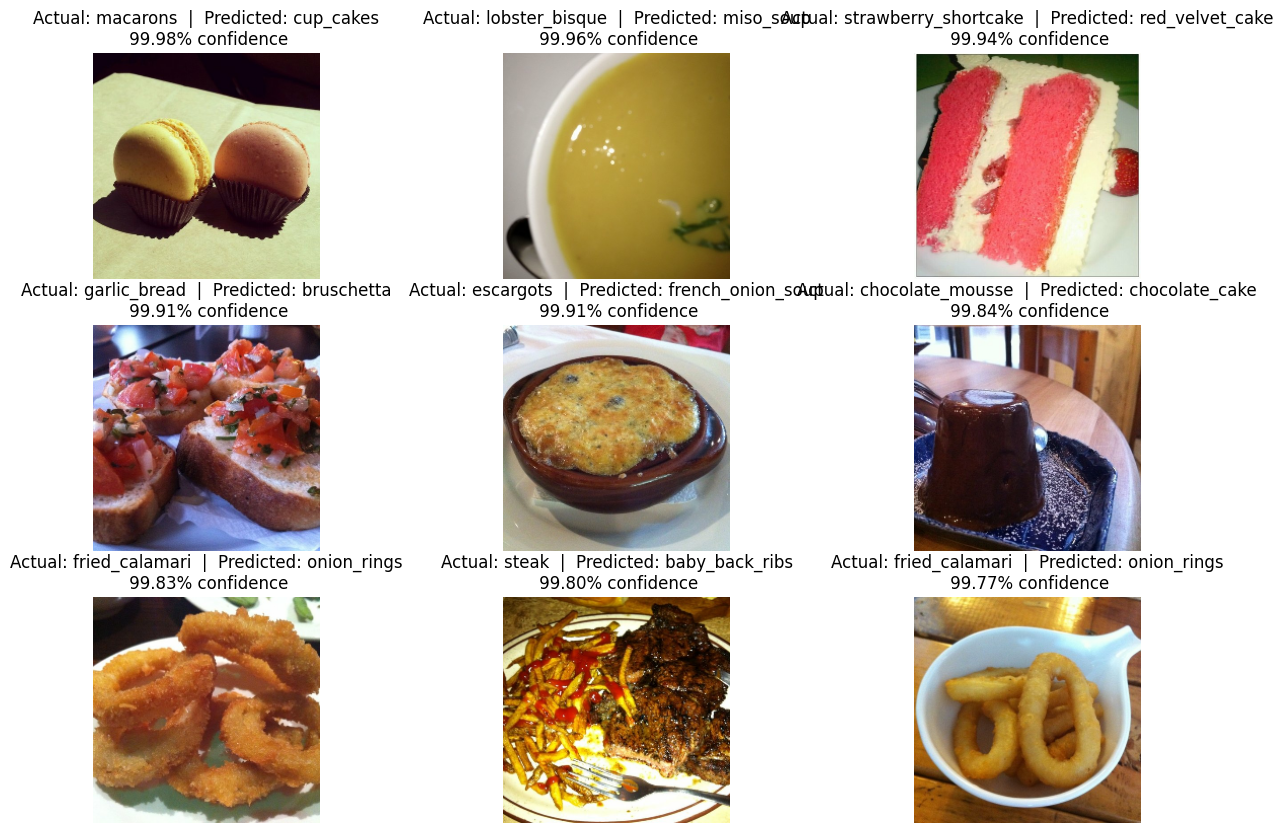

In [107]:
#Display the top 9 wrong prediction images
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_wrong[0:9].itertuples()):
  img = load_image(path=row[1], scale=False)
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.) #Matplotlib needs normalized data to plot correctly
  plt.axis(False)
  plt.title(f'Actual: {row[5]}  |  Predicted: {row[6]}\n {row[4]*100:.2f}% confidence')

You can modify the code below if you want to predict and display your custom images

In [ ]:
## Get the file paths
# !wget ~path~
# path_list = ['dirname/' + img_path for img_path in os.listdir('dirname')]
## Make predictions and plot food images
# for img in path_list:
#   img = load_image(img, scale=False)
#   prob = loaded_model.predict(tf.expand_dims(img, axis=0))
#   pred_class = class_names[prob.argmax()]
## Plot it!
# plt.figure()
# plt.imshow(img/255.)
# plt.title(f'pred: {pred_class}, prob: {prob.max():.2f}')
# plt.axis(False)